In [5]:
import sys
!{sys.executable} --version

import math
import numpy as np
from datetime import datetime
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from IPython.display import display

%matplotlib inline

from scipy.optimize import minimize
from math import log

Python 3.7.4


# get price histories

In [6]:
# https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average

companies, tickers = ['Honeywell','Salesforce'],['HON','CRM']

tickers_df = yf.download(tickers, 
                      start='2017-01-01', 
                      end='2021-09-04', 
                      progress=False, auto_adjust=True)
display(tickers_df.head())
display(tickers_df.tail())

returns = tickers_df['Close'].applymap(log).diff()[1:]

stats = returns.agg(['mean', 'std', 'var'])

Close                   High                    Low  \
                  CRM         HON        CRM         HON        CRM   
Date                                                                  
2017-01-03  70.540001  101.104836  70.860001  101.731413  69.000000   
2017-01-04  72.800003  101.383316  73.070000  101.792329  70.760002   
2017-01-05  72.790001  101.609543  73.660004  102.218712  72.529999   
2017-01-06  73.800003  103.149902  74.129997  103.306548  72.550003   
2017-01-09  73.959999  102.297058  74.440002  103.028057  73.510002   

                             Open               Volume           
                   HON        CRM         HON      CRM      HON  
Date                                                             
2017-01-03  100.565285  69.290001  101.496447  8112200  3155931  
2017-01-04  100.974296  71.080002  101.505146  9289500  3069124  
2017-01-05  101.139612  72.809998  101.409387  4695600  2766030  
2017-01-06  101.392013  72.889999  101.766217  4466100  3770361  
2017-01-09  102.297058  74.050003  102.923629  3933100  4030573

Close                    High                     Low  \
                   CRM         HON         CRM         HON         CRM   
Date                                                                     
2021-08-30  264.970001  231.869995  267.579987  232.779999  264.750000   
2021-08-31  265.269989  231.910004  266.769989  232.649994  262.700012   
2021-09-01  268.320007  229.800003  273.260010  233.190002  265.589996   
2021-09-02  264.149994  230.970001  269.260010  231.440002  263.920013   
2021-09-03  267.079987  228.360001  267.410004  231.000000  261.799988   

                              Open               Volume           
                   HON         CRM         HON      CRM      HON  
Date                                                              
2021-08-30  230.559998  265.809998  231.220001  5730000  1318300  
2021-08-31  230.570007  264.769989  231.429993  5901500  1956300  
2021-09-01  229.300003  266.269989  232.949997  7189000  2484300  
2021-09-02  229.770004  269.000000  230.919998  4498300  1594500  
2021-09-03  227.770004  263.600006  231.000000  7356700  1622400

# get the EWMA volatility estimates
## and the percentage of days that are exceptions

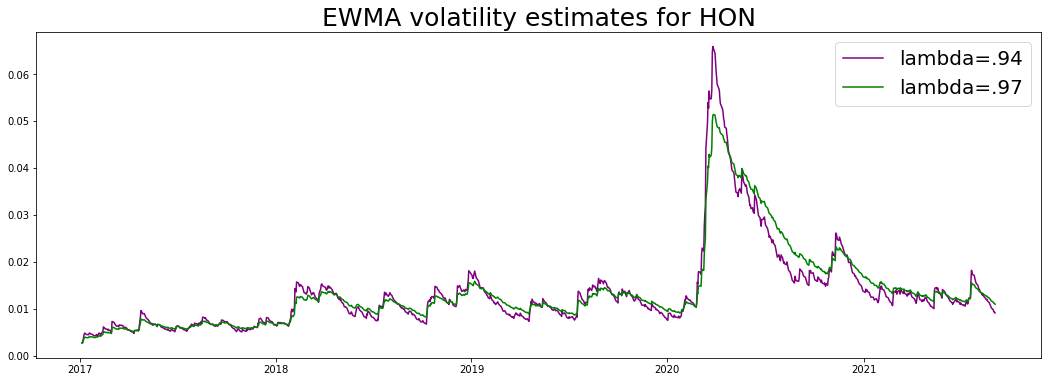

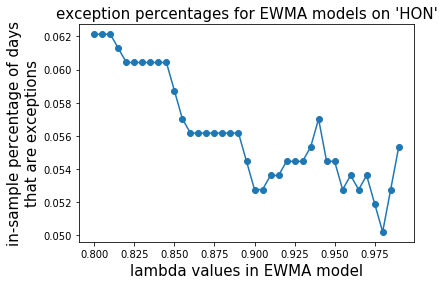

In [13]:
def rolling_vol(wt, r):
    sigma = []
    sigma2 = r[0] * r[0]
    for r0 in r:
        sigma2 = wt * sigma2 + (1 - wt) * r0 * r0
        sigma.append(np.sqrt(sigma2))
    sigma = pd.DataFrame(sigma[:-1], index = r.index[1:])
    return sigma

def exception_counter(wt, r):
    sigma = rolling_vol(wt, r)
    exceptions = sum([1 for s0, r0 in zip(sigma.iloc[:,0], r[1:]) if r0 < -1.645 * s0])
    return exceptions, len(r) - 1, exceptions/(len(r) - 1)

ticker = tickers[0]
r = returns[ticker]
v94 = rolling_vol(.94, r)
v97 = rolling_vol(.97, r)

lambda_fits = pd.DataFrame([(lambda0, exception_counter(lambda0, r)[0], len(r)-1) 
     for lambda0 in np.arange(.80,.995,.005)], columns=['lambda','exceptions','days'])

plt.figure(figsize=(18,6))
plt.plot(v94, color='purple', label='lambda=.94')
plt.plot(v97, color='green', label='lambda=.97')
plt.title(f"EWMA volatility estimates for {ticker}",fontsize=25)
plt.legend(fontsize=20)
plt.show()

lambda_fits['percentages'] = lambda_fits['exceptions'] /  lambda_fits['days']
plt.plot(lambda_fits['lambda'], lambda_fits['percentages'], 'o-')
plt.title(f"exception percentages for EWMA models on '{ticker}'",fontsize=15)
plt.xlabel("lambda values in EWMA model",fontsize=15)
plt.ylabel("in-sample percentage of days\nthat are exceptions",fontsize=15)
plt.show()


## use an optimizer to calculate the best fit values of lambda

In [14]:
def count_pct(wt):
    ec = exception_counter(wt,r)
#     print(wt, ec, pow(ec[2] - .05, 2))
    return pow(ec[2] - .05, 2)

X0 = 0.90
res1 = minimize(count_pct, X0, method='Powell', tol= 1e-10)
print(res1)
print()
xx = res1['x']
print(f"'{ticker}': best fit value of lambda = {xx:0.4f}\n")
print(exception_counter(xx, r), count_pct(xx))

C:\Users\Elliot\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
C:\Users\Elliot\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in multiply
  """


   direc: array([[1.]])
     fun: array(7.6505206e-06)
 message: 'Optimization terminated successfully.'
    nfev: 49
     nit: 1
  status: 0
 success: True
       x: array(0.95572809)

'HON': best fit value of lambda = 0.9557

(62, 1175, 0.05276595744680851) 7.65052059755543e-06
